# CamK Stats and Plots

In [34]:
header = "200323_camk_coupling"
cc_threshold = 0.07
cc_strong = 1.0

# Raw Traces
wt_stim = '2019_02_25_0016_1-2_ch0.csv' # Ch 1 -> 0
wt_rec = '2019_02_25_0016_1-2_ch2.csv'
wt_stim_nmda = '2019_02_25_0017_1-2_ch0.csv'
wt_rec_nmda = '2019_02_25_0017_1-2_ch2.csv'

camt_stim = '2019_03_12_0023_2-1_ch2.csv'
camt_rec = '2019_03_12_0023_2-1_ch0.csv'
camt_stim_nmda = '2019_03_12_0024_2-1_ch2.csv'
camt_rec_nmda = '2019_03_12_0023_2-1_ch0.csv'

camko_stim = '2019_09_19_0007_1-2_ch0.csv' # channel 1->2
camko_rec = '2019_09_19_0007_1-2_ch2.csv'
camko_stim_nmda = '2019_09_19_0009_1-2_ch0.csv' # channel 1->2
camko_rec_nmda = '2019_09_19_0009_1-2_ch2.csv' # channel 1->2

camkb_stim = '2019_08_01_0009_2-1_ch2.csv' # CH 2 -> 1
camkb_rec = '2019_08_01_0009_2-1_ch0.csv' # CH 2 -> 1
camkb_stim_nmda = '2019_08_01_0012_2-1_ch2.csv' # CH 2 -> 1
camkb_rec_nmda = '2019_08_01_0012_2-1_ch0.csv' # CH 2 -> 1



### Package Imports

In [35]:
import mysql.connector
from mysql.connector import errorcode
from ephyspy import mysql_manager 
import configparser
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import random
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import pyabf

base = importr('base')
utils = importr('utils')
desc_tools = importr('DescTools')
fsa = importr('FSA')
rcompanion = importr('rcompanion')
mcv = importr('multcompView')
lsmeans = importr('lsmeans')
stats = importr('stats')
dunnett = ro.r['DunnettTest']

### mySQL Connection info

In [36]:
config = configparser.ConfigParser()
config.read('config.ini')
DB_NAME = config.get('connections', 'DB_NAME')
USER_NAME = config.get('connections', 'DB_USER')
PWD = config.get('connections', 'DB_PWD')
HOST_NAME = config.get('connections','DB_HOST')
PORT = config.get('connections', 'DB_PORT')

### Download raw data from database

In [37]:
cnx = mysql.connector.connect(user = USER_NAME, 
    password = PWD, host = HOST_NAME, database = DB_NAME, 
    port = PORT)
cursor = cnx.cursor(buffered = True)
mysql_manager.locate_database(cursor, DB_NAME)

sql = "SELECT * FROM camk_coupling "
cursor.execute(sql)
search = cursor.fetchall()
df = pd.DataFrame()

for item in search:
    row = [{'id': item[0],'file': item[1], 'strain': item[2],'mouse': item[3],'distance': item[4],'conc_nmda': item[5],
            'vm1': item[6],'vm2': item[7],'vrec1': item[8],'vstim1': item[9],'istim1': item[10],'vrec2': item[11],'vstim2':item[12],
          'istim2': item[13],'vm1_nmda': item[14],'vm2_nmda': item[15],'vrec1_nmda': item[16],'vstim1_nmda': item[17],'istim1_nmda': item[18],
            'vrec2_nmda': item[19],'vstim2_nmda': item[20],'istim2_nmda': item[21], 'cc1': item[22], 'cc2': item[23], 
          'rin1': item[24], 'rin2': item[25], 'xfer1': item[26], 'xfer2': item[27], 'gj1': item[28], 'gj2': item[29], 'cc1_nmda': item[30], 
            'cc2_nmda': item[31], 'rin1_nmda': item[32], 'rin2_nmda': item[33], 'xfer1_nmda': item[34], 
          'xfer2_nmda': item[35], 'gj1_nmda': item[36], 'gj2_nmda': item[37], 'cc1_pchange': item[38], 'cc2_pchange': item[39], 
            'gj1_pchange': item[40], 'gj2_pchange': item[41], 'gin1': item[42], 'gin2': item[43],
          'gin1_nmda': item[44], 'gin2_nmda': item[45], 'bins': item[46], 'vrec1_pchange': item[47], 'vrec2_pchange': item[48],
            'vstim1_pchange': item[49], 'vstim2_pchange': item[50]}]
    df = df.append(row)
display(HTML(df.to_html()))
df.to_csv(header + '.csv')

Data base haleygee_olive  is alive.


,id,file,strain,mouse,distance,conc_nmda,vm1,vm2,vrec1,vstim1,istim1,vrec2,vstim2,istim2,vm1_nmda,vm2_nmda,vrec1_nmda,vstim1_nmda,istim1_nmda,vrec2_nmda,vstim2_nmda,istim2_nmda,cc1,cc2,rin1,rin2,xfer1,xfer2,gj1,gj2,cc1_nmda,cc2_nmda,rin1_nmda,rin2_nmda,xfer1_nmda,xfer2_nmda,gj1_nmda,gj2_nmda,cc1_pchange,cc2_pchange,gj1_pchange,gj2_pchange,gin1,gin2,gin1_nmda,gin2_nmda,bins,vrec1_pchange,vrec2_pchange,vstim1_pchange,vstim2_pchange
0,1,2019_02_25_0008.abf,WT,1.1,20,5,-62.7481,-46.5260,0.151550,-30.2067,-200.0,-0.677868,-82.24530,-200.0,-61.9914,-49.7562,-0.766903,-27.7009,-200.0,0.043171,-81.5578,-200.0,0.000000,0.824203,151.0330,411.2260,-0.757751,3.389340,-12.200500,54.581000,2.768510,0.000000,138.5040,407.7890,3.834510,-0.215855,67.908600,-3.82176,0.00,-100.00,-656.61,-107.00,6.62105,2.43175,7.21999,2.45225,5.0,-606.03900,-106.369000,-8.29555,-0.835942
0,2,2019_02_25_0016.abf,WT,1.1,30,5,-39.0338,-52.6284,-0.167004,-13.0387,-200.0,-0.193592,-14.94810,-200.0,-37.9090,-54.9970,-0.288219,-16.3532,-200.0,-0.051102,-16.2277,-200.0,1.280830,1.295090,65.1935,74.7405,0.835018,0.967960,171.395000,198.692000,1.762470,0.314904,81.7659,81.1384,1.441100,0.255508,217.285000,38.51330,37.60,-75.68,26.77,-80.62,15.33900,13.37960,12.23000,12.32460,5.0,72.58270,-73.603400,25.42040,8.560150
0,3,2019_03_05_0005.abf,WT,1.1,0,5,-61.0847,-44.9697,-0.198891,-146.9080,-200.0,-0.728729,-14.86050,-200.0,-31.8339,-42.6250,-0.067886,-100.5100,-200.0,-1.066610,-18.9261,-200.0,0.135385,4.903790,734.5390,74.3027,0.994453,3.643650,18.221000,66.776300,0.067542,5.635660,502.5490,94.6307,0.339432,5.333060,7.137440,112.20800,-50.11,14.92,-60.83,68.04,1.36140,13.45850,1.98985,10.56740,5.0,-65.86750,46.366100,-31.58310,27.358400
0,4,2019_03_11_0009.abf,WT,1.1,10,5,-50.7003,-51.1630,-0.049526,-83.8788,-200.0,-0.104237,-61.84810,-200.0,-9999.0000,-9999.0000,-9999.000000,-9999.0000,-9999.0,-9999.000000,-9999.0000,-9999.0,0.059045,0.168536,419.3940,309.2410,0.247631,0.521183,1.909350,4.018580,-9999.000000,-9999.000000,-9999.0000,-9999.0000,-9999.000000,-9999.000000,-9999.000000,-9999.00000,-9999.00,-9999.00,-9999.00,-9999.00,2.38439,3.23373,-9999.00000,-9999.00000,5.0,-9999.00000,-9999.000000,-9999.00000,-9999.000000
0,5,2019_03_20_0005.abf,WT,1.1,30,5,-44.3891,-45.1779,-0.005947,-35.5602,-300.0,0.059513,-7.23005,-300.0,-43.1547,-44.1740,-0.006439,-34.1557,-300.0,0.018967,-6.7301,-300.0,0.016724,0.000000,118.5340,24.1002,0.019824,-0.198377,6.939410,-69.444000,0.018853,0.000000,113.8520,22.4337,0.021464,-0.063222,8.403660,-24.75300,12.73,0.00,21.10,-64.36,8.43641,41.49350,8.78330,44.57580,5.0,8.27454,-68.130200,-3.94945,-6.914890
0,6,2019_03_20_0023.abf,WT,1.1,15,5,-50.2688,-32.9718,-0.559055,-22.5769,-300.0,-0.271053,-52.98160,-300.0,-44.3403,-26.5359,-0.586229,-24.0938,-300.0,-0.578640,-41.2605,-300.0,2.476230,0.511599,75.2563,176.6050,1.863520,0.903511,140.249000,67.985000,2.433120,1.402410,80.3125,137.5350,1.954100,1.928800,176.970000,174.67800,-1.74,174.12,26.18,156.94,13.28790,5.66234,12.45140,7.27088,5.0,4.86070,113.478000,6.71866,-22.123000
0,7,2019_03_25_0005.abf,WT,1.1,30,5,-56.3713,-60.5547,-0.135876,-19.9801,-300.0,-0.005589,-144.44100,-300.0,-54.8421,-61.0650,-0.014618,-26.5610,-300.0,-0.017433,-122.5440,-300.0,0.680056,0.003869,66.6003,481.4700,0.452919,0.018628,14.124700,0.580940,0.055035,0.014226,88.5365,408.4790,0.048726,0.058111,1.347320,1.60680,-91.91,267.69,-90.46,176.59,15.01500,2.07697,11.29480,2.44811,5.0,-89.24170,211.945000,32.93710,-15.160000
0,8,2019_03_25_0011.abf,WT,1.1,20,5,-26.6937,-26.9166,0.015558,-46.5369,-300.0,0.431704,-25.05670,-300.0,-30.9325,-22.1602,-0.007418,-34.4904,-300.0,0.295145,-23.0051,-300.0,0.000000,0.000000,155.1230,83.5224,-0.051861,-1.439010,-4.002770,-111.085000,0.021507,0.000000,114.9680,76.6838,0.024726,-0.983817,2.804570,-111.60500,0.00,0.00,-170.07,0.47,6.44650,11.97280,8.69808,13.04060,5.0,-147.67700,-31.632500,-25.88590,-8.187830
0,9,2019_03_25_0016.abf,WT,1.1,25,5,-28.8460,-40.6245,-0.043797,-18.9121,-300.0,-0.

### Function Definitions

In [38]:
def get_clean (df):
    """ Remove depolarized/bad cells """
    df = df[df.vm1 <= -35] 
    df = df[df.vm2 <= -35]
    return df

def get_connections(df):
    """ Sort individual connections from paired datasets"""
    df_ac = df[['id','file','strain','distance','vm1','vm2','cc1', 'rin1', 'gj1', 'cc1_nmda', 
          'rin1_nmda',  'gj1_nmda', 'cc1_pchange', 'gj1_pchange', 
            'gin1', 'gin1_nmda', 'bins', 'vrec1_pchange', 'vstim1_pchange']]
    df_ac.columns = ['id','file','strain','distance','vm1','vm1_nmda','cc', 'rin', 'gj', 'cc_nmda', 
          'rin_nmda',  'gj_nmda', 'cc_pchange', 'gj_pchange', 
            'gin', 'gin_nmda', 'bins', 'vrec_pchange', 'vstim_pchange']
    for index, row in df.iterrows():
        new = {'id':row.id,'file':row.file,'strain':row.strain,'distance':row.distance,'vm1': row.vm2,
           'vm1_nmda': row.vm2_nmda,'cc': row.cc2, 'rin': row.rin2, 
           'gj': row.gj2, 'cc_nmda': row.cc2_nmda, 'rin_nmda': row.rin2_nmda,  
           'gj_nmda': row.gj2_nmda, 'cc_pchange': row.cc2_pchange, 
           'gj_pchange': row.gj2_pchange, 'gin': row.gin2, 'gin_nmda': row.gin2_nmda, 
           'bins': row.bins, 'vrec_pchange': row.vrec2_pchange, 'vstim_pchange': row.vstim2_pchange}
        df_ac = df_ac.append(new, ignore_index = True)
    df_ac.to_csv(header + '_attempted_ctr.csv')
    return df_ac

def get_nmda_connections (df):
    """ Get connections with paired NMDA measurements """
    df_an = df[df.cc_nmda != -9999]
    df_an.to_csv(header + '_attempted_nmda.csv')
    return df_an

def get_connected(df, threshold):
    """ Get connected pairs based off the supplied threshold """
    df_connected = df[df.cc >= threshold]
    return df_connected

def get_subset (df, direction):
    if direction == 'strengthened':
        df_change = df[df.cc_pchange > 0]
    elif direction == 'weakened':
        df_change = df[df.cc_pchange < 0]
    elif direction == 'strong':
        df_change = df[df.cc >= cc_strong]
    elif direction == 'weak':
        df_change = df[df.cc < cc_strong]
    return df_change


def get_desc (df_temp, labels, pcon, exp):
    display(HTML("<br><h2> Descriptive Statistics</h2><br>"))
    df = df_temp.copy()
    df_avg = df.groupby('strain').mean()
    df_ste = df.groupby('strain').sem()
    df_std = df.groupby('strain').std()
    df_avg = df_avg.reset_index()
    df_ste = df_ste.reset_index()
    df_std = df_std.reset_index()

    df_desc = pd.DataFrame({ 'measure':[], 'strain': [], 'avg':[], 'ste':[], 'std':[], 'p_connected': []})
    for label in labels:
        for g in np.unique(df_avg.strain):
            row = {'measure': label, 'strain': g, 'avg': float(df_avg[df_avg.strain == g][label]), 
                   'ste': float(df_ste[df_ste.strain == g][label]), 
                   'std':float(df_std[df_std.strain == g][label]),
                   'p_connected': float(pcon[g])} 
            df_desc = df_desc.append(row, ignore_index = True)     
    display(HTML(df_desc.to_html()))
    df_desc.to_csv('camk_' + exp + '_desc.csv')
    return df_desc

def plot_desc_ctr (desc, df_temp, exp):
    display(HTML("<br><h2> Summary Plots </h2><br>"))
    df = df_temp.copy()
    for label in ctr_labels:
        fig, ax = plt.subplots (figsize = (5,5), dpi = 100)
        df['x_index'] = np.nan
        df.x_index = np.where(df.strain == groups[0], 0,  df.x_index)
        df.x_index = np.where(df.strain == groups[1], 1 , df.x_index)
        df.x_index = np.where(df.strain == groups[2], 2 , df.x_index)
        df.x_index = np.where(df.strain == groups[3], 3 , df.x_index)
        
        desc['x_index'] = np.nan
        desc.x_index = np.where(desc.strain == groups[0], 0,  desc.x_index)
        desc.x_index = np.where(desc.strain == groups[1], 1 , desc.x_index)
        desc.x_index = np.where(desc.strain == groups[2], 2 , desc.x_index)
        desc.x_index = np.where(desc.strain == groups[3], 3 , desc.x_index)
        
        i = 0
        for x in df.x_index:
            ax.plot (x + np.random.normal(loc = 0.5) * 0.1, df.iloc[i][label], ls = 'none', marker = 'o', color = 'gray')
            i = i + 1
        ax.plot (desc.x_index[0:4], desc.avg[desc.measure == label], ls = 'none', marker = 'o', color = 'black', mec = 'black', 
                 markersize = 10)
        ax.errorbar(desc.x_index[0:4], desc.avg[desc.measure == label], yerr = desc.ste[desc.measure == label], color = 'black', 
                       ls = 'none', elinewidth = 2, capsize = 6, capthick = 2)

        y_lims = ax.get_ylim ()
        y_range = y_lims[1] - y_lims[0]
        y_min = y_lims[0] - abs(y_lims[0]) * 0.1
        y_max = y_lims[1] + abs(y_lims[1]) * 0.1
        ax.set_ylim (y_min, y_max)
        ax.set_xlim (-.5, 3.5)
        ax.set(xticks=range(0, 4), xticklabels=list(groups))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylabel(ylabels[label], fontsize = 18)
        plt.tick_params (labelsize = 16, pad = 10)
        plt.tight_layout()
        plt.show()
        plt.savefig('camk_' + exp + '_' + label + '.jpg', dpi=300)

def get_one_way_anova(dep_var, strain, label, df_anovas, exp):
    """User passes the the dependent variable and measurement label. 
    The function calculates the linear model, summarizes the data, 
    then performs an anova. Output is saved as a .csv spreadsheet in
    the working directory."""
    
    df_anova = pd.DataFrame()
    ro.globalenv['dep_var'] = dep_var
    lm_x = stats.lm("dep_var ~ strain")
    lm_summary = base.summary(lm_x)
    anova_results = stats.anova(lm_x)
    anova_summary = base.summary(anova_results)
    
    # Parse the chaotic output of lm() and anova() into a pandas dataframe
    df_groups = int(anova_results[0][0])
    df_err = int(anova_results[0][1])
    ss_groups = float(anova_results[1][0])
    ss_err = float(anova_results[1][1])
    ms_groups = float(anova_results[2][0])
    ms_err = float(anova_results[2][1])
    f_stat = float(anova_results[3][0])    
    p_value = float(anova_results[4][0])
    row = {'measure': label, 'df_group': df_groups, 'ss_groups': ss_groups, 
            'ss_err':ss_err, 'ms_groups': ms_groups, 'ms_err': ms_err, 
            'df_err': df_err, 'f_stat': f_stat, 'p_value': p_value}
    df_anova = df_anova.append(row, ignore_index = True)
    df_anova = df_anova[['measure', 'df_group', 'df_err', 'ss_groups',
                       'ss_err', 'ms_groups', 'ms_err','f_stat', 'p_value']]
    df_anovas = df_anovas.append(df_anova)
    return df_anovas

def get_ctr_one_way_anova(df, exp):    
    """ Cycle through the measurements and perform one way anova on each 
    with strain as the ind. var"""
    display(HTML("<br><h2> One-Way Anovas</h2><br>"))
    vm1 = ro.vectors.FloatVector(df.vm1)
    cc = ro.vectors.FloatVector(df.cc)
    rin  = ro.vectors.FloatVector(df.rin)
    gj  = ro.vectors.FloatVector(df.gj)
    gin  = ro.vectors.FloatVector(df.gin)
    bins = ro.vectors.FactorVector(df.bins)
    strain = ro.vectors.FactorVector(df.strain)
    distance = ro.vectors.FactorVector(df.distance)

    ro.globalenv['vm1'] = vm1
    ro.globalenv['cc'] = cc
    ro.globalenv['rin']  = rin
    ro.globalenv['gj']  = gj
    ro.globalenv['gin']  = gin
    ro.globalenv['bins'] = bins
    ro.globalenv['distance'] = distance
    ro.globalenv['strain'] = strain

    measures = {'vm1':vm1, 'cc':cc, 'rin':rin, 'gj':gj, 'gin':gin}
    
    #cc1_nmda  = ro.vectors.FloatVector(df.cc1_nmda)
    #rin1_nmda  = ro.vectors.FloatVector(df.rin1_nmda)
    #gj1_nmda  = ro.vectors.FloatVector(df.gj1_nmda)
    #cc1_pchange  = ro.vectors.FloatVector(df.cc1_pchange)
    #gj1_pchange = ro.vectors.FloatVector(df.gj1_pchange)
    #gin1_nmda  = ro.vectors.FloatVector(df.gin1_nmda)
    #vrec1_pchange  = ro.vectors.FloatVector(df.vrec1_pchange)
    #vstim1_pchange  = ro.vectors.FloatVector(df.vstim1_pchange)
    #ro.globalenv['cc1_nmda']  = cc1_nmda
    #ro.globalenv['rin1_nmda']  = rin1_nmda
    #ro.globalenv['gj1_nmda']  = gj1_nmda
    #ro.globalenv['cc1_pchange']  = cc1_pchange
    #ro.globalenv['gj1_pchange'] = gj1_pchange
    #ro.globalenv['gin1_nmda']  = gin1_nmda
    #ro.globalenv['vrec1_pchange']  = vrec1_pchange
    #ro.globalenv['vstim1_pchange']  = vstim1_pchange

    df_anovas = pd.DataFrame()
    i = 0
    for label in ctr_labels:
        df_anovas = get_one_way_anova(measures[label], strain, label, df_anovas, exp)
        i = i + 1
        
    df_anovas.to_csv('camk_coupling_anova_' + exp + '_' + label + '.csv', index = True) # Save the dataframe to a csv spreadsheet
    display(HTML(df_anovas.to_html())) # Display the results in a table
    return measures, strain, bins, distance

def get_dunnett(dep_var, label, df_dunnett, strain):
    """User passes the the dependent variable and measurement label. 
    The function performs planned comparisons using the Dunnett test 
    and summarizes the data. Output is saved as a .csv spreadsheet in
    the working directory."""
        
    df_dun = pd.DataFrame()
    dunnett_results = dunnett(x = dep_var, g = strain, control = 'WT')
    pairs = base.labels(dunnett_results[0])
    calculations = base.labels(dunnett_results[0][1])
    i = 0
    for pair in pairs[0]:
        groups = pair.split('-')
        row = {'measurement': label,
                'group1': groups[0],
                'group2': groups[1],
                'diff': dunnett_results[0][i],
                'lwr_ci': dunnett_results[0][i+3],
                'upr_ci': dunnett_results[0][i+6],
                'p_val': dunnett_results[0][i+9]}
        df_dun = df_dun.append(row, ignore_index = True)
        i = i + 1
    df_dun = df_dun[['measurement','group1', 'group2', 'diff', 'lwr_ci', 'upr_ci', 'p_val']]
    df_dunnett = df_dunnett.append(df_dun, ignore_index = True)
    #display(HTML(df_dun.to_html()))
    return df_dunnett

def start_dunnett(measures, strain, exp, labels):
    """Cycle through the measurements and perform Dunnett planned comparisons on 
     each with strain as the ind. var""" 
    display(HTML("<br><h2> Dunnett Posthoc Analysis</h2><br>"))
    df_dunnett = pd.DataFrame()
    i = 0
    for label in labels:
        df_dunnett = get_dunnett(measures[label], label, df_dunnett, strain)
        i = i+1
    df_dunnett.to_csv('camk_' + exp + '_dunnett.csv', index = True) # Save the dataframe to a csv spreadsheet
    display(HTML(df_dunnett.to_html())) # Display the results in a table


def get_nmda_one_way_anova(df, exp):    
    """ Cycle through the measurements and perform one way anova on each 
    with strain as the ind. var"""
    display(HTML("<br><h2> One-Way Anovas</h2><br>"))
    vm1 = ro.vectors.FloatVector(df.vm1)
    cc = ro.vectors.FloatVector(df.cc)
    rin  = ro.vectors.FloatVector(df.rin)
    gj  = ro.vectors.FloatVector(df.gj)
    gin  = ro.vectors.FloatVector(df.gin)
    bins = ro.vectors.FactorVector(df.bins)
    strain = ro.vectors.FactorVector(df.strain)
    distance = ro.vectors.FactorVector(df.distance)

    ro.globalenv['vm1'] = vm1
    ro.globalenv['cc'] = cc
    ro.globalenv['rin']  = rin
    ro.globalenv['gj']  = gj
    ro.globalenv['gin']  = gin
    ro.globalenv['bins'] = bins
    ro.globalenv['distance'] = distance
    ro.globalenv['strain'] = strain
   
    vm1_nmda = ro.vectors.FloatVector(df.vm1_nmda)
    cc_nmda  = ro.vectors.FloatVector(df.cc_nmda)
    rin_nmda  = ro.vectors.FloatVector(df.rin_nmda)
    gj_nmda  = ro.vectors.FloatVector(df.gj_nmda)
    cc_pchange  = ro.vectors.FloatVector(df.cc_pchange)
    gj_pchange = ro.vectors.FloatVector(df.gj_pchange)
    gin_nmda  = ro.vectors.FloatVector(df.gin_nmda)
    vrec_pchange  = ro.vectors.FloatVector(df.vrec_pchange)
    vstim_pchange  = ro.vectors.FloatVector(df.vstim_pchange)
    ro.globalenv['vm1_nmda'] = vm1_nmda
    ro.globalenv['cc_nmda']  = cc_nmda
    ro.globalenv['rin_nmda']  = rin_nmda
    ro.globalenv['gj_nmda']  = gj_nmda
    ro.globalenv['cc_pchange']  = cc_pchange
    ro.globalenv['gj_pchange'] = gj_pchange
    ro.globalenv['gin_nmda']  = gin_nmda
    ro.globalenv['vrec_pchange']  = vrec_pchange
    ro.globalenv['vstim_pchange']  = vstim_pchange

    measures = {'vm1':vm1, 'cc':cc, 'rin':rin, 'gj':gj, 'gin':gin, 
               'vm1_nmda': vm1_nmda, 'cc_nmda': cc_nmda, 'rin_nmda':rin_nmda, 
                'gj_nmda':gj_nmda,  'cc_pchange':cc_pchange, 
                'gj_pchange':gj_pchange, 'gin_nmda':gin_nmda, 
                'vrec_pchange':vrec_pchange, 'vstim_pchange':vstim_pchange}
    
    df_anovas = pd.DataFrame()
    i = 0
    for label in labels:
        df_anovas = get_one_way_anova(measures[label], strain, label, df_anovas, exp)
        i = i + 1
        
    df_anovas.to_csv('camk_coupling_anova_' + exp + '_' + label + '.csv', index = True) # Save the dataframe to a csv spreadsheet
    display(HTML(df_anovas.to_html())) # Display the results in a table
    return measures, strain, bins, distance

def plot_traces (traces, exp):
    display (HTML('<h3> Plots </h3>'))
    for keys, values in ctr_traces.items():
        df_stim = pd.read_csv(values[0])
        if len(df_stim.x) > 4000:
            df_stim = df_stim[500::]
        
        df_rec = pd.read_csv(values[1])
        if len(df_rec.x) > 4000:
            df_rec = df_rec[500::]
        cc = str(values[2])
        x = np.arange(0,len(df_stim.x)) / 10000 # sample rate
        
        fig, ax_stim = plt.subplots (figsize = (8,8), dpi = 100)
        
        # Average stim traces
        ax_stim.plot(x, df_stim.avg, lw = 4, color = 'k', label = 'Stimulus')
        stim_min = -123
        stim_max = -3
        stim_range = stim_max - stim_min
        rec_range = 10
                       
        # Normalize vm
        vm_stim = df_stim.avg[0:50].mean()      
        vm_rec = df_rec.avg[0:50].mean()
        vm_adj = abs(stim_max-vm_stim) / (stim_range/rec_range)                
        
        ax_rec = ax_stim.twinx()
        ax_rec.plot(x, df_rec.avg, lw = 4, color = 'dimgray', label = 'Record')
        
        # Set axis_limits
        ax_stim.set_xlim(0, 0.35)
        ax_stim.set_ylim(stim_min, stim_max) # range = 120
        ax_rec.set_ylim(vm_rec - (rec_range - vm_adj), vm_rec + (vm_adj)) # range - 5
    
        # Annotate cc
        ax_stim.annotate("% CC = " + cc, xy = (.125, vm_stim - vm_stim * 0.1), fontsize = 14)
        ax_stim.axhline(vm_stim, ls = ':', color = 'gray')
        ax_stim.annotate(str(round(vm_stim,2)) + " mV", xy = (0, vm_stim - vm_stim * 0.08), fontsize = 12)
        ax_stim.annotate(str(round(vm_rec,2)) + " mV", xy = (0, vm_stim + vm_stim * 0.18), fontsize = 12, color = "dimgray")
        
        # Prettify
        ax_stim.spines['top'].set_visible(False)
        ax_stim.spines['right'].set_visible(False)
        ax_stim.spines['left'].set_visible(False)
        ax_stim.spines['bottom'].set_visible(False)
        ax_rec.spines['top'].set_visible(False)
        ax_rec.spines['right'].set_visible(False)
        ax_rec.spines['left'].set_visible(False)
        ax_rec.spines['bottom'].set_visible(False)
        ax_stim.set_xticks([])
        ax_stim.set_yticks([])
        ax_rec.set_yticks([])
        
        # scale bar
        ax_stim.plot([0.32, 0.35], [vm_stim + vm_stim * 0.7]*2, color = 'black', lw = 3)
        ax_stim.plot([0.32]*2, [vm_stim + vm_stim * 0.7, (vm_stim + vm_stim * 0.7) + 10], color = 'black', lw = 3)
        ax_stim.annotate(str(10) + " ms", xy = (0.32, vm_stim + vm_stim * 0.8), fontsize = 14)
        ax_stim.annotate(str(10) + " mV", xy = (0.28, vm_stim + vm_stim * 0.55), fontsize = 14, color = "black")
        ax_stim.annotate(' ' + str(8) + "  mV", xy = (0.28, vm_stim + vm_stim * 0.65), fontsize = 14, color = "dimgray")
        plt.savefig('camk_' + exp + '_' + keys + '.jpg', dpi=300) 
        
def plot_desc_nmda (desc, df_temp, exp):
    display(HTML("<br><h2> Summary Plots </h2><br>"))
    df = df_temp.copy()
    for label in labels:
        
        df['x_index'] = np.nan
        df.x_index = np.where(df.strain == groups[0], 0,  df.x_index)
        df.x_index = np.where(df.strain == groups[1], 1 , df.x_index)
        df.x_index = np.where(df.strain == groups[2], 2 , df.x_index)
        df.x_index = np.where(df.strain == groups[3], 3 , df.x_index)
        
        desc['x_index'] = np.nan
        desc.x_index = np.where(desc.strain == groups[0], 0,  desc.x_index)
        desc.x_index = np.where(desc.strain == groups[1], 1 , desc.x_index)
        desc.x_index = np.where(desc.strain == groups[2], 2 , desc.x_index)
        desc.x_index = np.where(desc.strain == groups[3], 3 , desc.x_index)
        
        if label + '_nmda' in labels:
            fig, ax = plt.subplots (figsize = (7,5), dpi = 100)
            i = 0
            for x in df.x_index:
                ax.plot ((x + np.random.normal(loc = 0.2) * 0.05)-.2, df.iloc[i][label], ls = 'none', marker = 'o', color = 'gray', markersize = 3)
                ax.plot ((x + np.random.normal(loc = 0.2) * 0.05)+.2, df.iloc[i][label + '_nmda'], ls = 'none', marker = 'o', markersize = 3, color = 'red', alpha = .5)
                i = i + 1
            ax.plot (desc.x_index[desc.measure == label] - 0.2, desc.avg[desc.measure == label], ls = 'none', marker = 'o', color = 'black', mec = 'black', markersize = 5)
            ax.plot (desc.x_index[desc.measure == label] + 0.2, desc.avg[desc.measure == label + '_nmda'], ls = 'none', marker = 'o', color = 'red', mec = 'red', markersize = 5)
            ax.errorbar(desc.x_index[desc.measure == label] - 0.2, desc.avg[desc.measure == label], yerr = desc.ste[desc.measure == label], color = 'black', ls = 'none', elinewidth = 2, capsize = 6, capthick = 2)
            ax.errorbar(desc.x_index[desc.measure == label + '_nmda'] + 0.2, desc.avg[desc.measure == label + '_nmda'], yerr = desc.ste[desc.measure == label + "_nmda"], color = 'red', ls = 'none', elinewidth = 2, capsize = 6, capthick = 2)
            ax.set_ylabel(ylabels[label], fontsize = 18)
        
        elif 'change' in label: 
            fig, ax = plt.subplots (figsize = (5,5), dpi = 100)
            i = 0
            for x in df.x_index:
                ax.plot (x + np.random.normal(loc = 0.5) * 0.1, df.iloc[i][label], ls = 'none', marker = 'o', color = 'gray')
                i = i + 1
            ax.plot (desc.x_index[0:4], desc.avg[desc.measure == label], ls = 'none', marker = 'o', color = 'black', mec = 'black', markersize = 10)
            ax.errorbar(desc.x_index[0:4], desc.avg[desc.measure == label], yerr = desc.ste[desc.measure == label], color = 'black',ls = 'none', elinewidth = 2, capsize = 6, capthick = 2)
            ax.set_ylabel(ylabels[label], fontsize = 18)
        else: 
            continue
        y_lims = ax.get_ylim ()
        y_range = y_lims[1] - y_lims[0]
        y_min = y_lims[0] - abs(y_lims[0]) * 0.1
        y_max = y_lims[1] + abs(y_lims[1]) * 0.1
        ax.set_ylim (y_min, y_max)
        ax.set_xlim (-.5, 3.5)
        ax.set(xticks=range(0, 4), xticklabels=list(groups))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        plt.tick_params (labelsize = 16, pad = 10)
        plt.tight_layout()
        plt.show()
        plt.savefig('camk_' + exp + '_' + label + '.jpg', dpi=300)    



### Clean and Subset the data

In [39]:
df_clean = get_clean(df) # Clean the data by removing bad cells
df_ac = get_connections(df_clean) # Sort pairs into individual attempted connections
n_ac = df_ac.groupby('strain').count() # Get sample sizes for each genotype
#display(HTML(df_ac.to_html()))

df_an = get_nmda_connections (df_ac) # Get attempted connections with paired NMDA
n_an = df_an.groupby('strain').count()
#display(HTML(df_an.to_html()))

df_cc = get_connected (df_ac,cc_threshold)  # Get connections that are stronger than the threshold CC
df_cc.to_csv(header + '_connected_ctr.csv')
n_cc = df_cc.groupby('strain').count()
display(HTML(df_cc.to_html()))

df_cn = get_connected (df_an, cc_threshold) # Get NMDA connections that are stronger than threshold CC
df_cn.to_csv(header + '_connected_nmda.csv')
n_cn = df_cn.groupby('strain').count()
#display(HTML(df_cn.to_html()))

df_sc = get_subset (df_cc, 'strong')  # Get strong connections 
df_sc.to_csv(header + "_strong_ctr.csv")
n_sc = df_sc.groupby('strain').count()
#display(HTML(df_sc.to_html()))

df_sn = get_subset (df_cn, 'strong')  # Get strong connections with paired nmda measurements
df_sn.to_csv(header + "_strong_nmda.csv")
n_sn = df_sn.groupby('strain').count()
#display(HTML(df_sn.to_html()))

df_wc = get_subset (df_cc, 'weak') # Get weak connections
df_wc.to_csv(header + "_weak_ctr.csv")
n_wc = df_wc.groupby('strain').count()
#display(HTML(df_wc.to_html()))

df_wn = get_subset (df_cn, 'weak') # Get weak connections with paired nmda measurements
df_wn.to_csv(header + "_weak_nmda.csv")
n_wn = df_wn.groupby('strain').count()
#display(HTML(df_wn.to_html()))

df_st = get_subset (df_cn, 'strengthened') # Get connections strengthened by NMDA
df_st.to_csv(header + '_strengthened.csv')
n_st = df_st.groupby('strain').count()
#display(HTML(df_st.to_html()))

df_wk = get_subset (df_cn, 'weakened') # Get connections weakened by NMDA
df_wk.to_csv(header + '_weakened.csv')
n_wk = df_wk.groupby('strain').count()
#display(HTML(df_wk.to_html()))

n = {'ac': n_ac.iloc[:,0], 'an': n_an.iloc[:,0], 'cc': n_cc.iloc[:,0], 'cn': n_cn.iloc[:,0], 'sc': n_sc.iloc[:,0], 
     'sn': n_sn.iloc[:,0], 'wc': n_wc.iloc[:,0], 'wn': n_wn.iloc[:,0], 'st': n_st.iloc[:,0], 'wk': n_wk.iloc[:,0]}

p_conn = {'cc': n_cc.iloc[:,0] / n_ac.iloc[:,0], 
          'cn': n_cn.iloc[:,0] / n_an.iloc[:,0], 
          'sc': n_sc.iloc[:,0] / n_cc.iloc[:,0], 
          'sn': n_sn.iloc[:,0] / n_cn.iloc[:,0], 
          'wc': n_wc.iloc[:,0] / n_cc.iloc[:,0], 
          'wn': n_wn.iloc[:,0] / n_cn.iloc[:,0], 
          'st': n_st.iloc[:,0] / n_cn.iloc[:,0], 
          'wk': n_wk.iloc[:,0] / n_cn.iloc[:,0]}

dfs = {'attC':df_ac, 'attN': df_an, 'conC':df_cc, 'conN':df_cn, 'strC':df_sc, 
       'strN': df_sn, 'wkC': df_wc, 'wkN':df_wn, 'str':df_st, 'wkn':df_wk}

groups = ['WT', 'T286A', 'KO', 'KB']

ctr_labels = ['vm1', 'cc', 'rin', 'gj',  'gin']

nmda_labels = ['vm1','vm1_nmda','cc', 'rin', 'gj', 'cc_nmda', 'rin_nmda', 
          'gj_nmda',  'cc_pchange', 'gj_pchange',  'gin', 'gin_nmda', 'vrec_pchange', 
          'vstim_pchange']

markers = itertools.cycle(('s', 'v', '^', 'o')) 

colors = itertools.cycle(('black', 'dimgray', 'silver', 'white'))

mecs = itertools.cycle(('white', 'black', 'dimgray', 'black'))
ylabels = {'vm1': 'Resting Vm (mV)\n', 'vm1_pchange': '% Change in Resing Membrane Potential \n', 
           'cc': '% CC\n', 'cc_pchange': '% Change in CC \n',
           'rin': r'R$_Input$ (M$\Omega$)' +' \n', 'rin_pchange': '% Change in ' + r'R$_Input$' + '\n',
           'gj': 'Junctional Conductance (pS)\n', 'gj_pchange': '% Change in ' + r'G$_j$' + ' \n',
           'gin': r'Junctional Resistance (M$\Omega$)' + ' \n', 'vrec_pchange': '% Change in Recorded \n',
           'vstim_pchange': '% Change in Stimulated \n'}

ctr_traces = {'wt': [wt_stim, wt_rec, 1.28], 'camt': [camt_stim, camt_rec, 1.08], 
              'camko': [camko_stim, camko_rec, 0.49], 'camkb': [camkb_stim, camkb_rec, 1.27]}

nmda_traces = {'wt': [wt_stim_nmda, wt_rec_nmda, 1.76], 'camt': [camt_stim_nmda, camt_rec_nmda, 0.24], 
               'camko': [camko_stim_nmda, camko_rec_nmda, 1.46], 'camkb': [camkb_stim_nmda, camkb_rec_nmda, 1.68]}

,id,file,strain,distance,vm1,vm1_nmda,cc,rin,gj,cc_nmda,rin_nmda,gj_nmda,cc_pchange,gj_pchange,gin,gin_nmda,bins,vrec_pchange,vstim_pchange
1,2,2019_02_25_0016.abf,WT,30,-39.0338,-52.6284,1.280830,65.1935,171.39500,1.762470,81.7659,217.28500,37.60,26.77,15.33900,12.23000,5.0,72.582700,25.420400
2,3,2019_03_05_0005.abf,WT,0,-61.0847,-44.9697,0.135385,734.5390,18.22100,0.067542,502.5490,7.13744,-50.11,-60.83,1.36140,1.98985,5.0,-65.867500,-31.583100
5,7,2019_03_25_0005.abf,WT,30,-56.3713,-60.5547,0.680056,66.6003,14.12470,0.055035,88.5365,1.34732,-91.91,-90.46,15.01500,11.29480,5.0,-89.241700,32.937100
6,10,2019_03_25_0020.abf,WT,20,-48.5684,-44.7698,0.132056,417.9090,11.66120,0.218568,204.3940,20.90210,65.51,79.24,2.39287,4.89252,5.0,-19.050300,-51.091300
7,15,2019_03_26_0020.abf,WT,25,-48.7072,-51.0856,0.312263,423.7270,37.04040,0.673141,249.5620,76.73050,115.57,107.15,2.36001,4.00702,5.0,26.963400,-41.103100
9,19,2019_03_27_0007.abf,WT,0,-44.1423,-45.9442,2.458110,154.4930,215.13600,1.430840,122.8490,127.49200,-41.79,-40.74,6.47279,8.14007,5.0,-53.713600,-20.482300
10,20,2019_03_27_0015.abf,WT,0,-54.2409,-52.3979,0.533415,288.1090,24.90100,0.330536,253.7580,27.05540,-38.03,8.65,3.47091,3.94076,5.0,-45.422000,-11.922700
11,21,2019_03_27_0021.abf,WT,20,-46.7511,-57.7006,0.855209,117.2830,88.73680,0.665162,141.0710,35.03810,-22.22,-60.51,8.52642,7.08862,5.0,-6.446500,20.283100
13,26,2019_04_04_0024.abf,WT,0,-41.5464,-38.7360,0.850725,72.8390,31.41410,-9999.000000,-9999.0000,-9999.00000,-9999.00,-9999.00,13.72890,-9999.00000,5.0,-9999.000000,-9999.000000
15,28,2019_05_15_0005.abf,WT,0,-42.1003,-36.5916,1.774570,79.4077,132.34400,1.582970,98.7479,192.41300,-10.80,45.39,12.59320,10.12680,5.0,10.928500,24.355600


# Control Connected

,measure,strain,avg,ste,std,p_connected
0,vm1,KB,-44.287733,1.257578,6.160850,0.80000
1,vm1,KO,-42.435800,3.477838,6.023793,0.37500
2,vm1,T286A,-46.633573,2.565504,8.508813,0.50000
3,vm1,WT,-48.104630,1.241316,5.953145,0.71875
4,cc,KB,1.427639,0.338854,1.660041,0.80000
5,cc,KO,0.328992,0.221044,0.382860,0.37500
6,cc,T286A,0.407454,0.089374,0.296421,0.50000
7,cc,WT,1.097939,0.245681,1.178245,0.71875
8,rin,KB,223.910383,27.361704,134.044429,0.80000
9,rin,KO,180.586333,46.251377,80.109735,0.37500


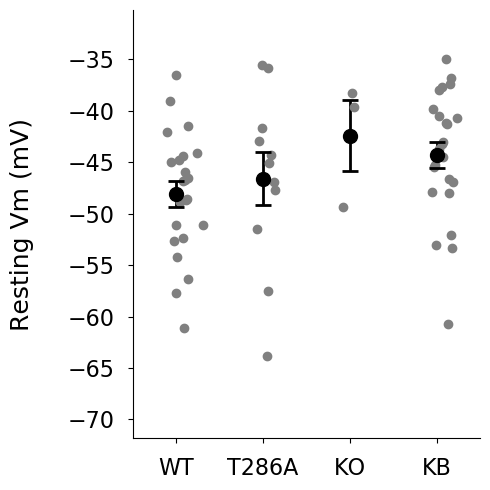

<Figure size 432x288 with 0 Axes>

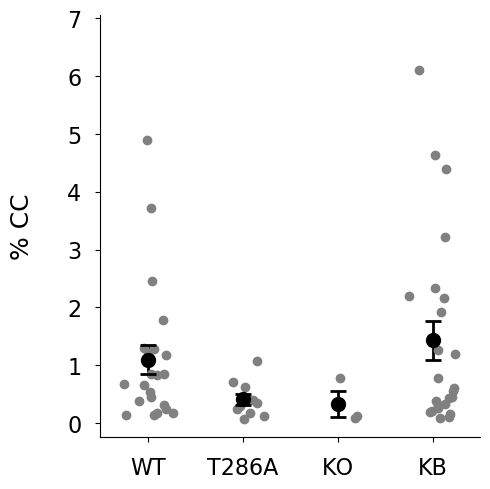

<Figure size 432x288 with 0 Axes>

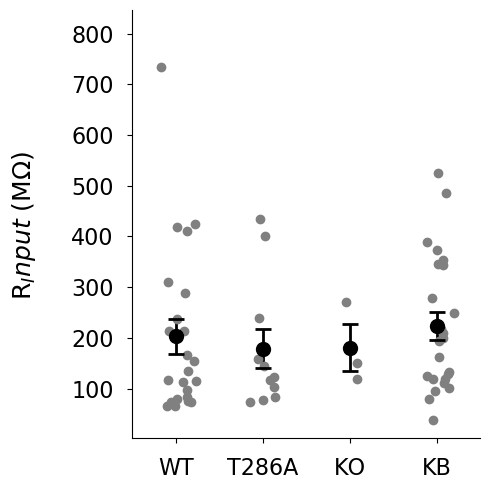

<Figure size 432x288 with 0 Axes>

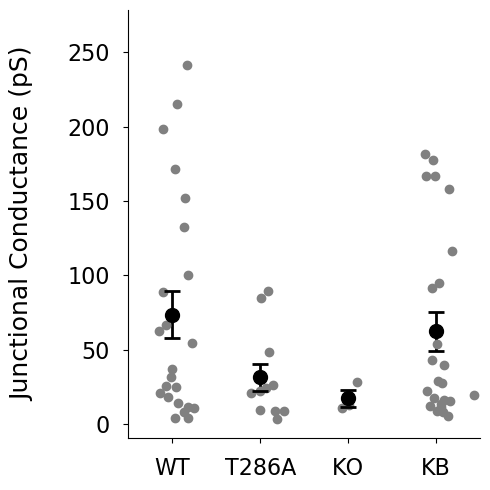

<Figure size 432x288 with 0 Axes>

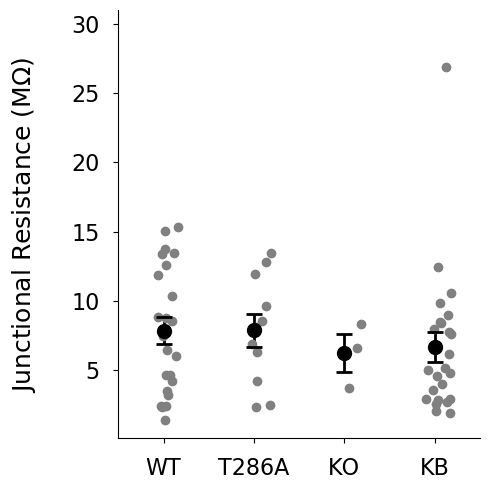

,measure,df_group,df_err,ss_groups,ss_err,ms_groups,ms_err,f_stat,p_value
0,vm1,3.0,57.0,214.557349,2.449239e+03,71.519116,42.969109,1.664431,0.184837
0,cc,3.0,57.0,9.562282,9.509551e+01,3.187427,1.668342,1.910536,0.138126
0,rin,3.0,57.0,18433.196785,1.189703e+06,6144.398928,20871.984737,0.294385,0.829286
0,gj,3.0,57.0,18756.734925,2.255369e+05,6252.244975,3956.788200,1.580131,0.204147
0,gin,3.0,57.0,23.671446,1.259545e+03,7.890482,22.097276,0.357079,0.784194


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,vm1,KB,WT,3.816897,-0.856008,8.489802,0.137142
1,vm1,KO,WT,5.668830,-4.161536,15.499196,0.394536
2,vm1,T286A,WT,1.471058,-4.399600,7.341715,0.892687
3,cc,KB,WT,0.329700,-0.591070,1.250471,0.746436
4,cc,KO,WT,-0.768947,-2.705967,1.168073,0.683981
5,cc,T286A,WT,-0.690485,-1.847266,0.466296,0.365744
6,rin,KB,WT,21.097527,-81.891428,124.086481,0.937006
7,rin,KO,WT,-22.226523,-238.883854,194.430808,0.991157
8,rin,T286A,WT,-24.733247,-154.120192,104.653697,0.947860
9,gj,KB,WT,-11.297559,-56.139064,33.543946,0.891133


<Figure size 432x288 with 0 Axes>

In [40]:
desc_cc = get_desc(df_cc, ctr_labels, p_conn['cc'], 'cc')
plot_desc_ctr (desc_cc, df_cc, 'cc')
measures, strain, bins, distance = get_ctr_one_way_anova(df_cc, 'cc')
start_dunnett (measures, strain, 'cc', ctr_labels)

# NMDA Connected

,measure,strain,avg,ste,std,p_connected
0,cc,KB,1.334438,0.366078,1.637150,0.833333
1,cc,KO,0.328992,0.221044,0.382860,0.500000
2,cc,T286A,0.455725,0.137710,0.364346,0.388889
3,cc,WT,1.192836,0.275855,1.233660,0.769231
4,cc_nmda,KB,0.930825,0.180370,0.806639,0.833333
5,cc_nmda,KO,0.180922,0.106781,0.184950,0.500000
6,cc_nmda,T286A,0.247508,0.090797,0.240225,0.388889
7,cc_nmda,WT,1.047427,0.288055,1.288219,0.769231
8,cc_pchange,KB,67.337000,50.450661,225.622214,0.833333
9,cc_pchange,KO,-39.176667,23.122075,40.048608,0.500000


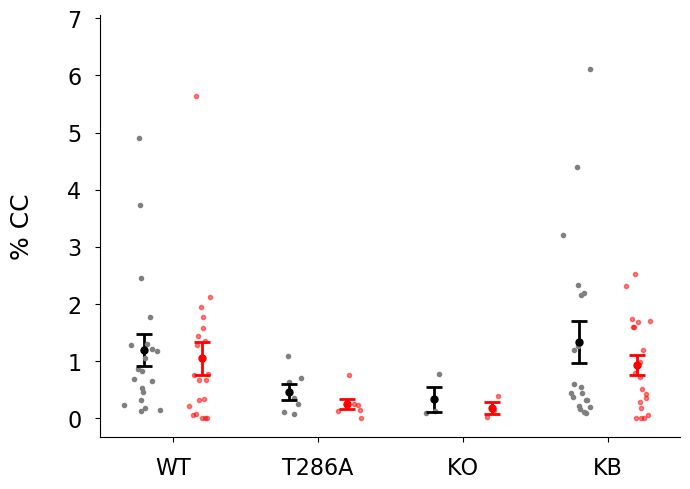

<Figure size 432x288 with 0 Axes>

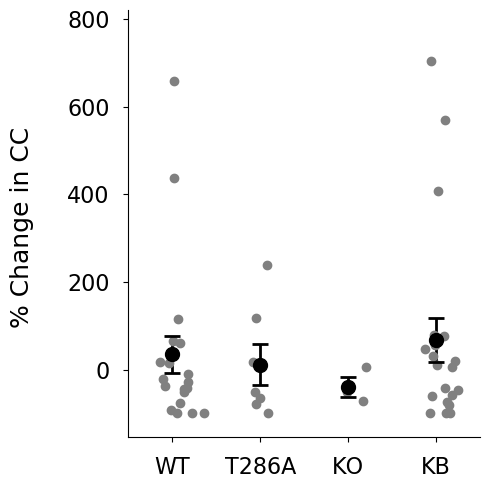

<Figure size 432x288 with 0 Axes>

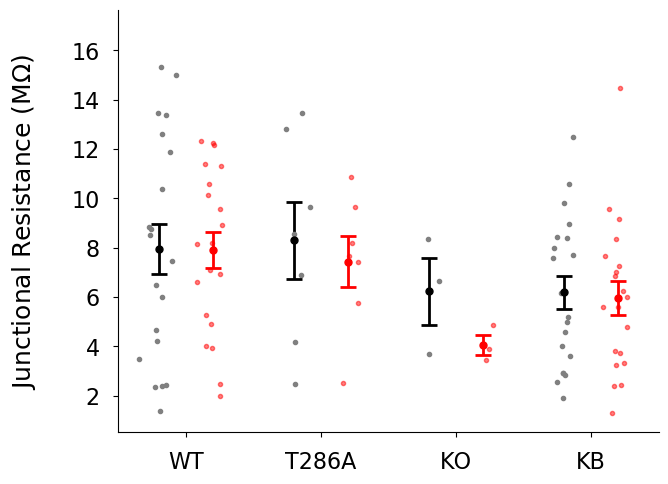

<Figure size 432x288 with 0 Axes>

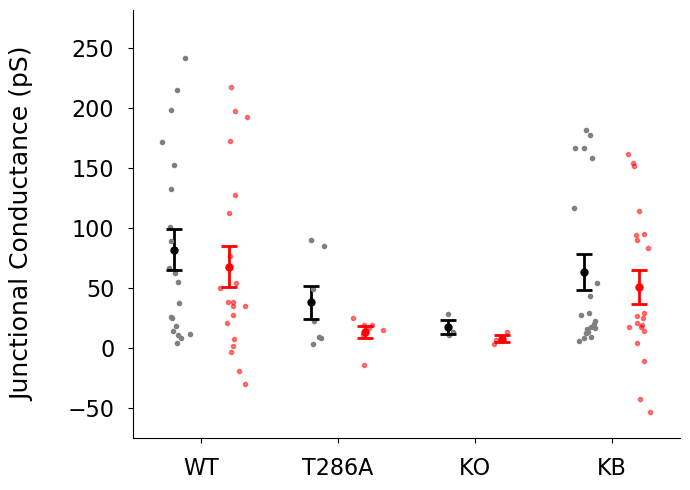

<Figure size 432x288 with 0 Axes>

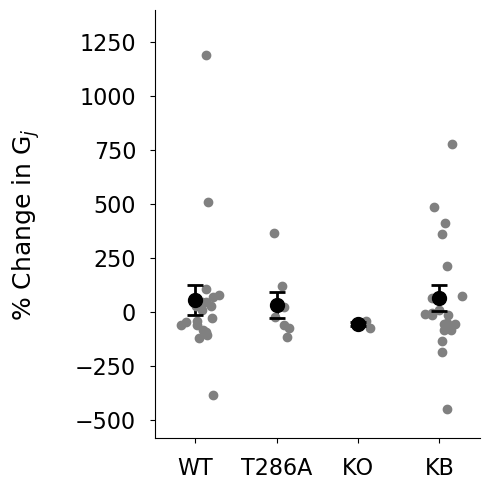

<Figure size 432x288 with 0 Axes>

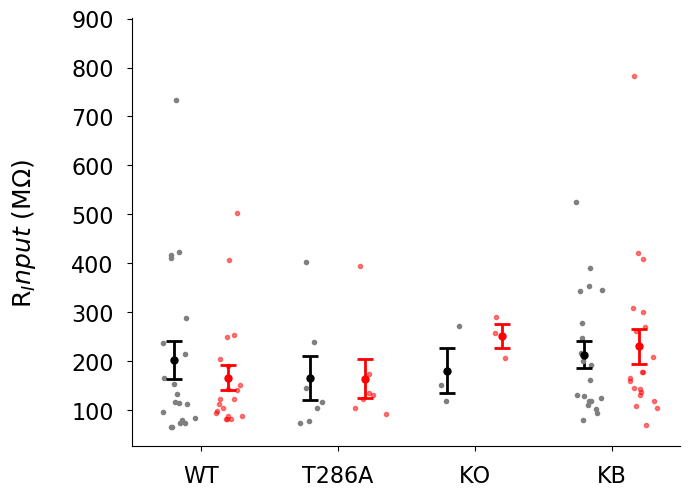

<Figure size 432x288 with 0 Axes>

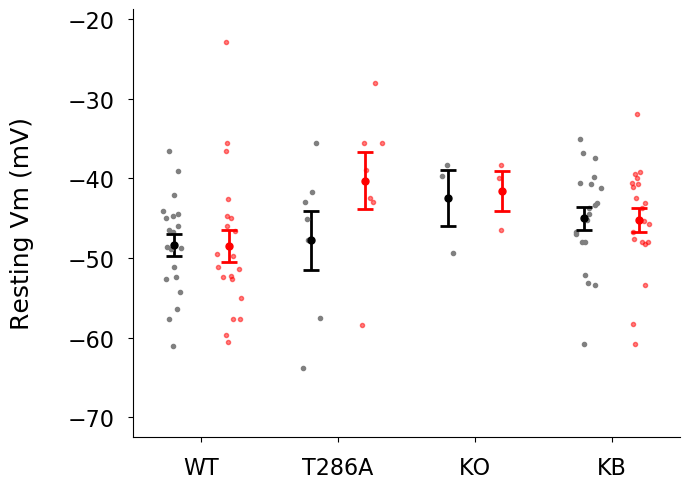

<Figure size 432x288 with 0 Axes>

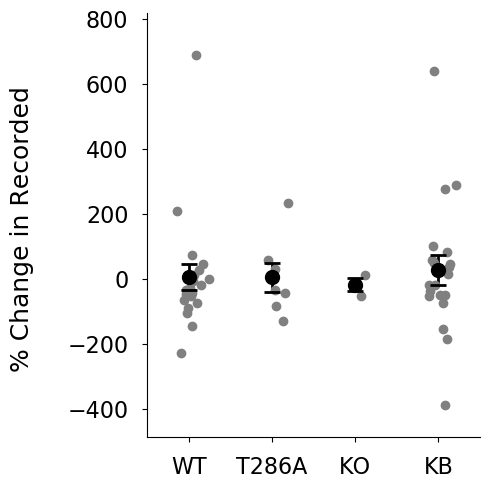

<Figure size 432x288 with 0 Axes>

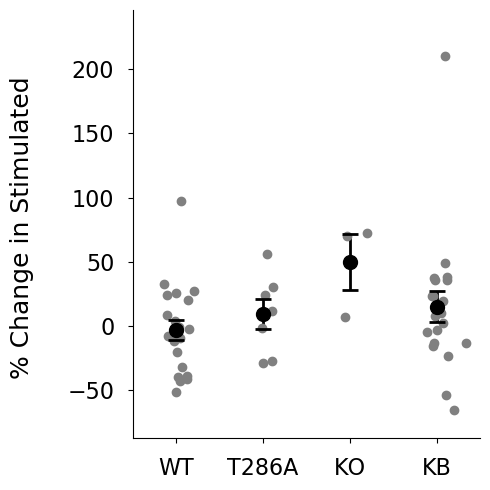

,measure,df_group,df_err,ss_groups,ss_err,ms_groups,ms_err,f_stat,p_value
0,cc,3.0,46.0,5.959050,8.093104e+01,1.986350,1.759371,1.129012,0.347206
0,cc_nmda,3.0,46.0,4.785475,4.430798e+01,1.595158,0.963217,1.656074,0.189580
0,cc_pchange,3.0,46.0,39920.857547,1.740025e+06,13306.952516,37826.629063,0.351788,0.788029
0,gin,3.0,46.0,43.089937,6.866593e+02,14.363312,14.927376,0.962213,0.418636
0,gin_nmda,3.0,46.0,64.462970,4.369310e+02,21.487657,9.498500,2.262216,0.093782
0,gj,3.0,46.0,17697.132005,2.087115e+05,5899.044002,4537.206463,1.300149,0.285761
0,gj_nmda,3.0,46.0,21085.001184,1.873662e+05,7028.333728,4073.178353,1.725516,0.174913
0,gj_pchange,3.0,46.0,39353.292276,3.383720e+06,13117.764092,73559.129961,0.178330,0.910551
0,rin,3.0,46.0,13288.749914,9.540288e+05,4429.583305,20739.755807,0.213579,0.886484
0,rin_nmda,3.0,46.0,57311.264317,8.175045e+05,19103.754772,17771.836582,1.074945,0.369042


,measurement,group1,group2,diff,lwr_ci,upr_ci,p_val
0,cc,KB,WT,0.141602,-0.891018,1.174223,0.979329
1,cc,KO,WT,-0.863845,-2.885602,1.157913,0.631687
2,cc,T286A,WT,-0.737111,-2.171142,0.696920,0.488272
3,cc_nmda,KB,WT,-0.116602,-0.880657,0.647452,0.971964
4,cc_nmda,KO,WT,-0.866505,-2.362439,0.629429,0.388510
5,cc_nmda,T286A,WT,-0.799919,-1.860984,0.261146,0.185202
6,cc_pchange,KB,WT,31.985500,-119.426708,183.397708,0.931033
7,cc_pchange,KO,WT,-74.528167,-370.976618,221.920284,0.890975
8,cc_pchange,T286A,WT,-23.988643,-234.259341,186.282055,0.987853
9,gin,KB,WT,-1.764273,-4.772107,1.243560,0.378099


<Figure size 432x288 with 0 Axes>

In [41]:
labels = np.unique(ctr_labels + nmda_labels)
desc_cn = get_desc(df_cn, labels, p_conn['cn'], 'cn')
plot_desc_nmda (desc_cn, df_cn, 'cn')
measures, strain, bins, distance = get_nmda_one_way_anova(df_cn, 'cn')
start_dunnett (measures, strain, 'cn', labels)

# Plot Traces

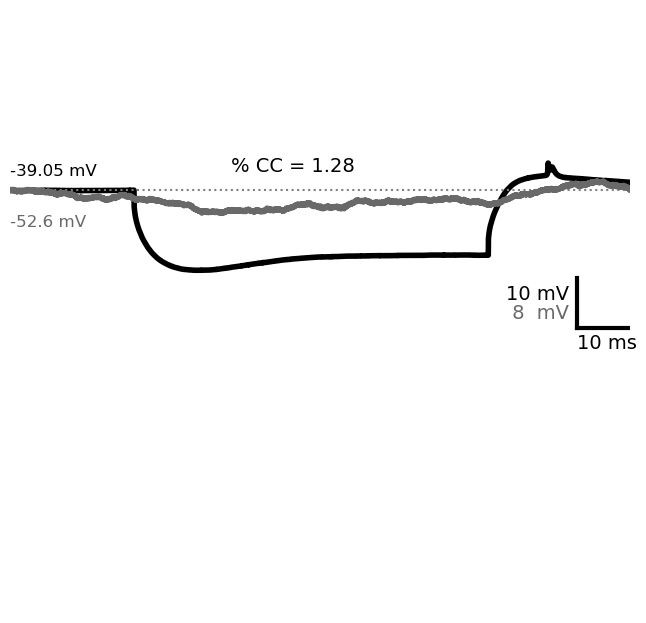

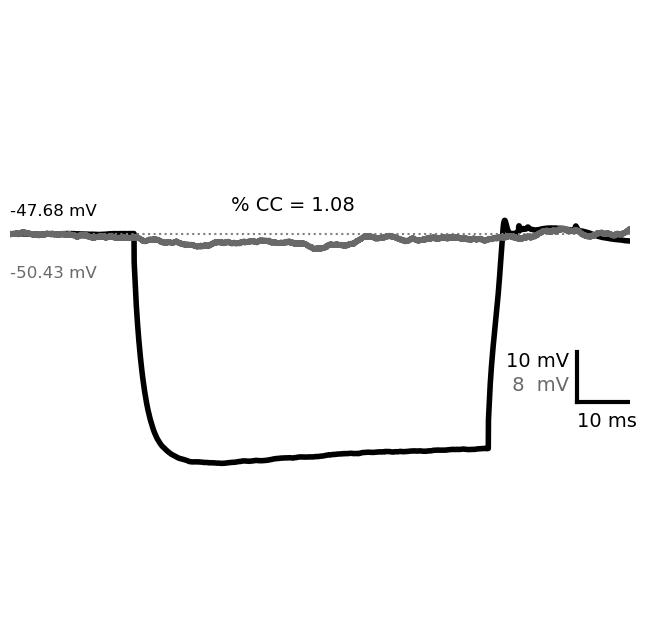

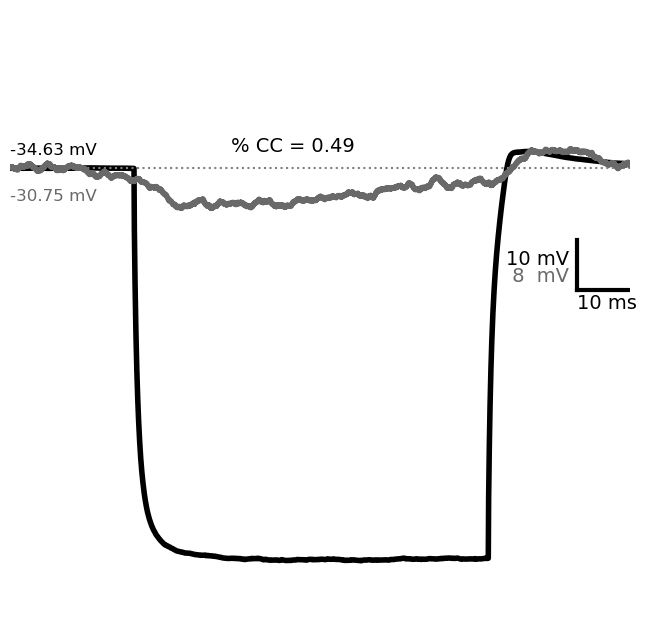

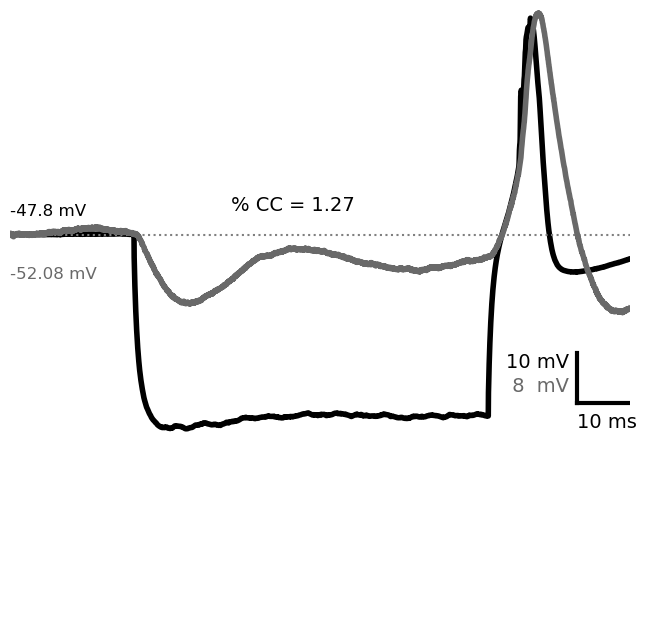

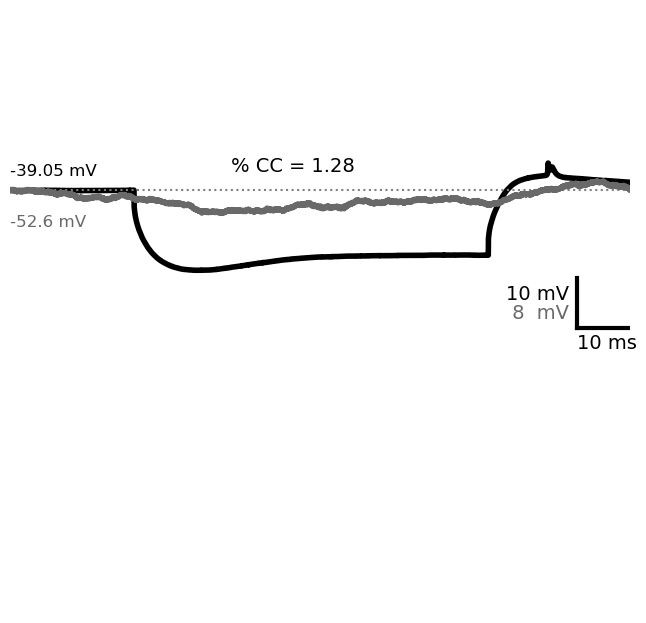

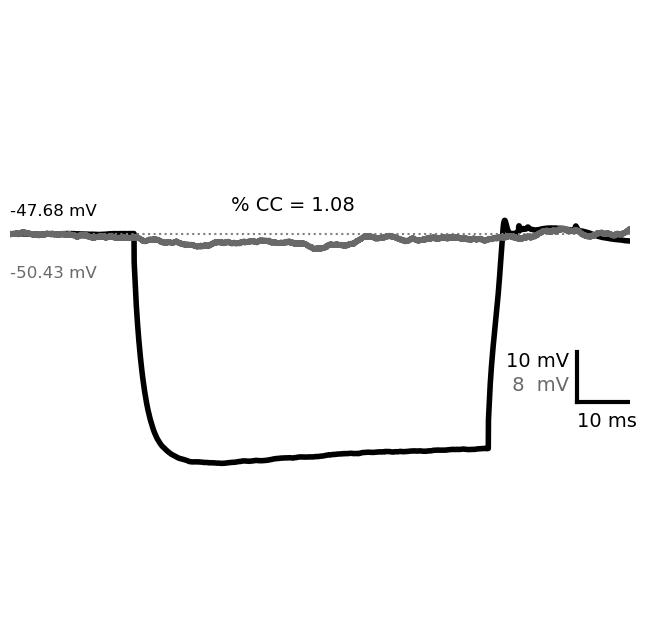

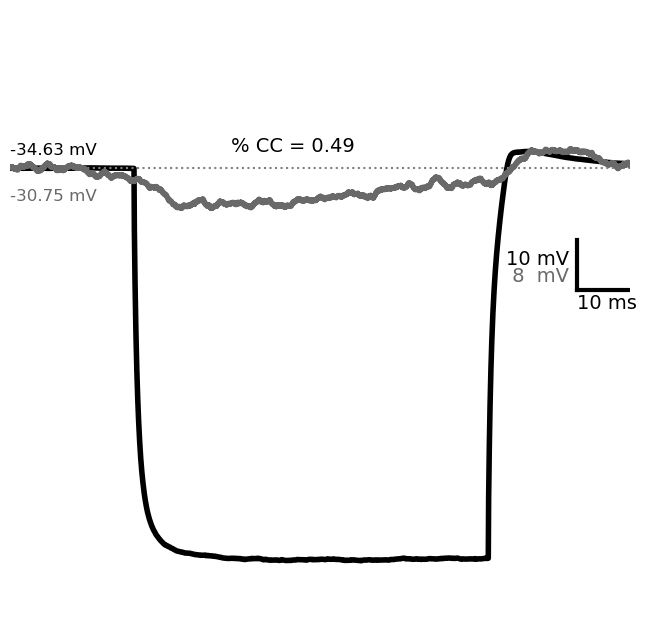

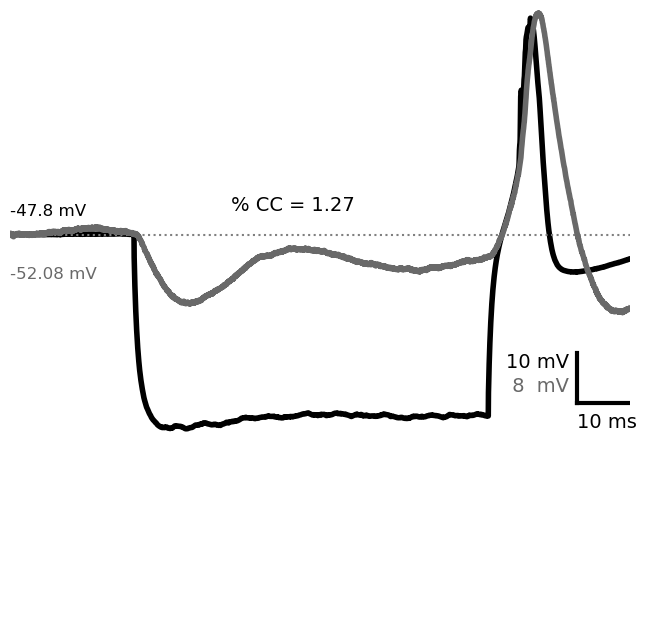

In [42]:
plot_traces(ctr_traces, 'ctr')
plot_traces(nmda_traces, 'nmda')